# Task 1: Understand body language by gesture recognition with fully connected neural network

## 1. Do literature search on gesture recognition and its application in Human-Robot Interaction. Summarize what you have learned.

## 2. Referring to the previous example about building a neural network based classifier, use what you have learned to read the code for gesture classification below and design your own network architecture using fully connected layers.

## 3. Run the model. Analyse and comment on the performance of your model based on fully connected layers.

In [1]:
import cv2
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as utils_data
from torchsummary import summary

## 1) data preprocessing

Define a function to preprocess the images including resizing and binaryzation

In [2]:
def processSkinImage(filePath, resize_HW=48):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    # cv2.imshow("", image_output)
    # cv2.waitKey(0)
    return image_output

Deal with all the images using the function defined above.
The processed data is stored in a new folder 'dataset_processed'.

Generate labels for each class. (class 0, 1, ..., num_classes)


In [5]:
path = './dataset/images'
path_processed = './dataset_processed/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        print(currentPath)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './dataset_processed/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

./dataset/images/right/right (4).jpg
./dataset/images/right/right (13).jpg
./dataset/images/right/right (8).jpg
./dataset/images/right/right (24).jpg
./dataset/images/right/right (9).jpg
./dataset/images/right/right (12).jpg
./dataset/images/right/right (5).jpg
./dataset/images/right/right (23).jpg
./dataset/images/right/right (19).jpg
./dataset/images/right/right (2).jpg
./dataset/images/right/right (15).jpg
./dataset/images/right/right (14).jpg
./dataset/images/right/right (3).jpg
./dataset/images/right/right (18).jpg
./dataset/images/right/right (22).jpg
./dataset/images/right/right (21).jpg
./dataset/images/right/right (17).jpg
./dataset/images/right/right (1).jpg
./dataset/images/right/right (16).jpg
./dataset/images/right/right (20).jpg
./dataset/images/right/right (11).jpg
./dataset/images/right/right (6).jpg
./dataset/images/right/right (7).jpg
./dataset/images/right/right (10).jpg
./dataset/images/left/left (8).jpg
./dataset/images/left/left (25).jpg
./dataset/images/left/left

## 2) load data

In [41]:
Image = []
path_images = './dataset_processed/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        Image.append(cv2.imread(currentPath)[:, :, 0])
Image = np.array(Image)
dataset_size, H, W = Image.shape
print(Image.shape)
# for FCNN model, the image need to be stretched into one dimension: (b, h, w)->(b, h*w)
Image = Image.reshape(dataset_size, -1)


Label = []
path_labels = './dataset_processed/labels'
for file in os.listdir(path_labels):
    Label.append(np.loadtxt(os.path.join(path_labels, file)))
Label = np.array(list(itertools.chain.from_iterable(Label)))
num_classes = int(np.max(Label))+1

(78, 48, 48)


## 3) build your own neural network based on fully connected layers.

Design the neural network architecture

In [54]:
class FCNNModel(nn.Module):
    def __init__(self, input_layer_size, hidden_layer_size, num_classes):
        super(FCNNModel, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.ReLU(),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(hidden_layer_size, num_classes),
        )
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        out = self.fc4(x)
        return out

instantiate your model, set a optimizer and define a loss function.

In [31]:
device = torch.device("mps")

For apple silicon the training is using mps. For other devices, please change it to prefered one.

In [55]:
model = FCNNModel(input_layer_size=H*W, hidden_layer_size=int(H*W/2), num_classes=num_classes).to(device)
# if torch.cuda.is_available():
#     model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [56]:
print(model)

FCNNModel(
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=1152, bias=True)
    (1): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1152, out_features=1152, bias=True)
    (1): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=1152, out_features=1152, bias=True)
    (1): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=1152, out_features=4, bias=True)
  )
)


## 4) train and test

Encapsulate data

In [42]:
dataset = utils_data.TensorDataset(torch.Tensor(Image), torch.LongTensor(Label))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=16, shuffle=True)
print('Data is ready!')

Data is ready!


The following is the training and testing process in detail.

epoch=0	train loss=0.933984	train accuracy=0.710	test accuracy=0.750
epoch=1	train loss=0.811680	train accuracy=0.694	test accuracy=0.875
epoch=2	train loss=0.248118	train accuracy=0.887	test accuracy=0.625
epoch=3	train loss=0.209449	train accuracy=0.919	test accuracy=0.625
epoch=4	train loss=0.095192	train accuracy=0.984	test accuracy=0.688
epoch=5	train loss=0.219374	train accuracy=0.903	test accuracy=0.750
epoch=6	train loss=0.100034	train accuracy=0.952	test accuracy=0.750
epoch=7	train loss=0.081376	train accuracy=0.984	test accuracy=0.812
epoch=8	train loss=0.083496	train accuracy=0.952	test accuracy=0.812
epoch=9	train loss=0.101186	train accuracy=0.968	test accuracy=0.812
epoch=10	train loss=0.014710	train accuracy=1.000	test accuracy=0.812
epoch=11	train loss=0.010280	train accuracy=1.000	test accuracy=0.812
epoch=12	train loss=0.013427	train accuracy=1.000	test accuracy=0.812
epoch=13	train loss=0.096661	train accuracy=0.968	test accuracy=0.812
epoch=14	train loss=0.019131	t

epoch=119	train loss=0.041225	train accuracy=0.968	test accuracy=0.750
epoch=120	train loss=0.058316	train accuracy=0.984	test accuracy=0.875
epoch=121	train loss=0.025864	train accuracy=0.984	test accuracy=0.875
epoch=122	train loss=0.004533	train accuracy=1.000	test accuracy=0.688
epoch=123	train loss=0.010324	train accuracy=1.000	test accuracy=0.688
epoch=124	train loss=0.005508	train accuracy=1.000	test accuracy=0.688
epoch=125	train loss=0.047736	train accuracy=0.984	test accuracy=0.812
epoch=126	train loss=0.044750	train accuracy=0.984	test accuracy=0.875
epoch=127	train loss=0.521842	train accuracy=0.952	test accuracy=0.812
epoch=128	train loss=0.087536	train accuracy=0.968	test accuracy=0.750
epoch=129	train loss=0.199365	train accuracy=0.952	test accuracy=0.625
epoch=130	train loss=0.011508	train accuracy=1.000	test accuracy=0.688
epoch=131	train loss=0.010612	train accuracy=1.000	test accuracy=0.812
epoch=132	train loss=0.075829	train accuracy=0.968	test accuracy=0.812
epoch=

epoch=239	train loss=0.005201	train accuracy=1.000	test accuracy=0.812
epoch=240	train loss=0.017698	train accuracy=1.000	test accuracy=0.812
epoch=241	train loss=0.001137	train accuracy=1.000	test accuracy=0.812
epoch=242	train loss=0.000545	train accuracy=1.000	test accuracy=0.812
epoch=243	train loss=0.018668	train accuracy=1.000	test accuracy=0.812
epoch=244	train loss=0.004051	train accuracy=1.000	test accuracy=0.812
epoch=245	train loss=0.001214	train accuracy=1.000	test accuracy=0.812
epoch=246	train loss=0.000498	train accuracy=1.000	test accuracy=0.812
epoch=247	train loss=0.000692	train accuracy=1.000	test accuracy=0.812
epoch=248	train loss=0.007131	train accuracy=1.000	test accuracy=0.812
epoch=249	train loss=0.000388	train accuracy=1.000	test accuracy=0.812
epoch=250	train loss=0.000493	train accuracy=1.000	test accuracy=0.812
epoch=251	train loss=0.054575	train accuracy=0.984	test accuracy=0.812
epoch=252	train loss=0.015221	train accuracy=1.000	test accuracy=0.750
epoch=

epoch=359	train loss=0.013652	train accuracy=1.000	test accuracy=0.750
epoch=360	train loss=0.015068	train accuracy=1.000	test accuracy=0.750
epoch=361	train loss=0.007850	train accuracy=1.000	test accuracy=0.750
epoch=362	train loss=0.013568	train accuracy=0.984	test accuracy=0.812
epoch=363	train loss=0.001254	train accuracy=1.000	test accuracy=0.812
epoch=364	train loss=0.391145	train accuracy=0.919	test accuracy=0.812
epoch=365	train loss=0.015709	train accuracy=1.000	test accuracy=0.812
epoch=366	train loss=0.074742	train accuracy=0.968	test accuracy=0.750
epoch=367	train loss=0.019686	train accuracy=1.000	test accuracy=0.750
epoch=368	train loss=0.007231	train accuracy=1.000	test accuracy=0.750
epoch=369	train loss=0.055335	train accuracy=0.984	test accuracy=0.750
epoch=370	train loss=0.000653	train accuracy=1.000	test accuracy=0.812
epoch=371	train loss=0.000837	train accuracy=1.000	test accuracy=0.750
epoch=372	train loss=0.002432	train accuracy=1.000	test accuracy=0.750
epoch=

epoch=476	train loss=0.000286	train accuracy=1.000	test accuracy=0.750
epoch=477	train loss=0.005748	train accuracy=1.000	test accuracy=0.750
epoch=478	train loss=0.001197	train accuracy=1.000	test accuracy=0.750
epoch=479	train loss=0.005370	train accuracy=1.000	test accuracy=0.750
epoch=480	train loss=0.000208	train accuracy=1.000	test accuracy=0.750
epoch=481	train loss=0.000624	train accuracy=1.000	test accuracy=0.750
epoch=482	train loss=0.000259	train accuracy=1.000	test accuracy=0.750
epoch=483	train loss=0.000329	train accuracy=1.000	test accuracy=0.750
epoch=484	train loss=0.000615	train accuracy=1.000	test accuracy=0.750
epoch=485	train loss=0.001590	train accuracy=1.000	test accuracy=0.750
epoch=486	train loss=0.000263	train accuracy=1.000	test accuracy=0.750
epoch=487	train loss=0.000271	train accuracy=1.000	test accuracy=0.750
epoch=488	train loss=0.001269	train accuracy=1.000	test accuracy=0.750
epoch=489	train loss=0.000178	train accuracy=1.000	test accuracy=0.750
epoch=

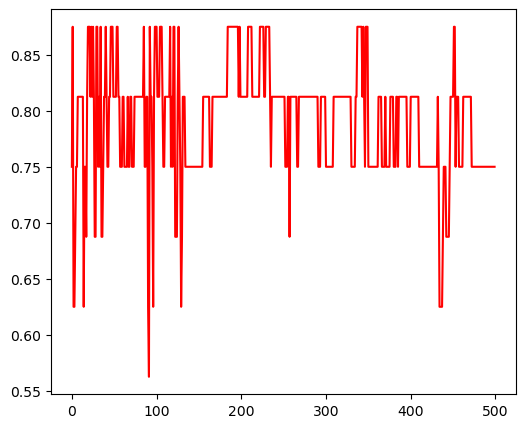

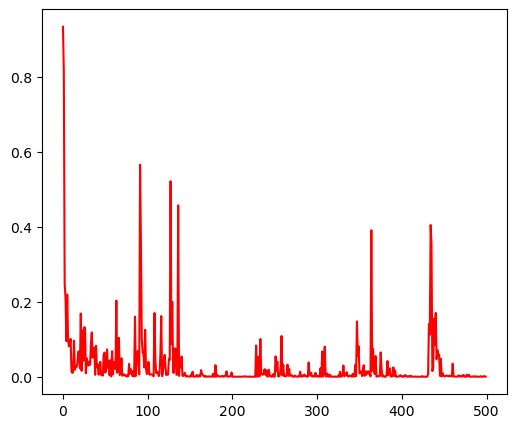

In [43]:
best_accuracy = 0
test1 = np.zeros(500)
loss1 = np.zeros(500)
for epoch in range(500):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        #batch_output = batch_output.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        # train accuracy
        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step+1)

    # ----------test----------
    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))
    test1[epoch] = test_acc
    loss1[epoch] = running_loss

    if test_acc >= best_accuracy:
        torch.save(model.state_dict(), './FCNN_model.pkl')
        best_accuracy = test_acc

plt.figure(figsize=(6, 5))
plt.plot(test1,'red')
plt.figure(figsize=(6, 5))
plt.plot(loss1,'red')
